## ESP_2025 - APLICAÇÃO 2 - TRIBUTAÇÃO ÓTIMA DO CONSUMO

## PRIMEIRA PARTE: REGRESSIVIDADE DA TRIBUTAÇÃO INDIRETA NO BRASIL

#### OBJETIVO: Utilizar um banco de micro dados baseado na Pesquisa de Orçamentos Familiares (POF) de 2017-2018 para analisar se a tributação indireta no Brasil é regressiva ou não.


In [31]:
# bibliotecas usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Configurações de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [32]:
caminho_arquivo = r"C:\{estudos}\ESP\Economia-do-Setor-Publico-2025.2\Aplicação 2\ESP_2025_aplicação 2_POF 2017-2018.xlsx"
df = pd.read_excel(caminho_arquivo, sheet_name=0)
print(f"Dados carregados: {len(df)} domicílios \n Colunas disponíveis: {df.columns.tolist()}")

Dados carregados: 57920 domicílios 
 Colunas disponíveis: ['ID_DOM', 'PESO', 'NUM_MOR', 'GASTO', 'RENDA', 'TI']


In [33]:
# Verificar colunas disponíveis e estatísticas básicas
print(f"\nEstatísticas básicas da RENDA:")
print(f"   Média: R$ {df['RENDA'].mean():.2f}")
print(f"   Mediana: R$ {df['RENDA'].median():.2f}")
print(f"   Mínimo: R$ {df['RENDA'].min():.2f}")
print(f"   Máximo: R$ {df['RENDA'].max():.2f}")

print(f"\nEstatísticas básicas do PESO:")
print(f"   Média: {df['PESO'].mean():.2f}")
print(f"   Mínimo: {df['PESO'].min():.2f}")
print(f"   Máximo: {df['PESO'].max():.2f}")


Estatísticas básicas da RENDA:
   Média: R$ 4674.93
   Mediana: R$ 2924.84
   Mínimo: R$ 0.00
   Máximo: R$ 675212.20

Estatísticas básicas do PESO:
   Média: 1188.92
   Mínimo: 6.00
   Máximo: 65991.00


### 1) CÁLCULO DO GASTO DOMICILIAR TOTAL

In [34]:
# CÁLCULO DOS TRIBUTOS COMO PROPORÇÃO DA RENDA E DO GASTO

df['TI_RENDA'] = (df['TI'] / df['RENDA']) * 100
df['TI_GASTO'] = (df['TI'] / df['GASTO']) * 100

df['TI_RENDA'] = df['TI_RENDA'].replace([np.inf, -np.inf], 0)


### 2) CÁLCULO DA RENDA PER CAPITA E DO GASTO PER CAPITA

In [35]:
df['RENDA_PC'] = df['RENDA'] / df['NUM_MOR']
df['GASTO_PC'] = df['GASTO'] / df['NUM_MOR']

### 3) CONSTRUÇÃO DOS DECIS DE RENDA PER CAPITA

In [36]:
# MÉTODO CORRETO: Usar os pesos para calcular os percentis ponderados
def weighted_quantile(values, weights, quantiles):
    """
    Calcula quantis ponderados
    """
    # Ordenar valores e pesos
    ind_sorted = np.argsort(values)
    values_sorted = values[ind_sorted]
    weights_sorted = weights[ind_sorted]
    
    # Calcular CDF ponderado
    cum_weights = np.cumsum(weights_sorted)
    cum_weights_normalized = cum_weights / cum_weights[-1]
    
    # Interpolar para encontrar os quantis
    return np.interp(quantiles, cum_weights_normalized, values_sorted)

# Calcular decis com pesos corretamente
quantiles = np.arange(0.1, 1.0, 0.1)  # 0.1, 0.2, ..., 0.9
deciles = weighted_quantile(df['RENDA_PC'].values, df['PESO'].values, quantiles)

print("Pontos de corte dos decis (com pesos corretos):")
for i, decil in enumerate(deciles, 1):
    print(f"  Decil {i}: R$ {decil:.2f}")

# Classificar domicílios nos decis
df['DECIL_RENDA_PC'] = pd.cut(df['RENDA_PC'], 
                             bins=[-np.inf] + list(deciles) + [np.inf],
                             labels=range(1, 11),
                             include_lowest=True)

# Distribuição por decil (com contagem simples)
distribuicao_decil = df['DECIL_RENDA_PC'].value_counts().sort_index()
print(f"\nDistribuição por decil (contagem simples):")
print(distribuicao_decil)

# Distribuição por decil (com pesos - população representada)
distribuicao_peso = df.groupby('DECIL_RENDA_PC')['PESO'].sum().round(0).astype(int)
print(f"\nPopulação representada por decil (com pesos):")
for decil, pop in distribuicao_peso.items():
    print(f"  Decil {decil}: {pop:,} pessoas")


Pontos de corte dos decis (com pesos corretos):
  Decil 1: R$ 396.33
  Decil 2: R$ 615.79
  Decil 3: R$ 825.33
  Decil 4: R$ 1059.16
  Decil 5: R$ 1293.29
  Decil 6: R$ 1581.63
  Decil 7: R$ 1998.97
  Decil 8: R$ 2709.99
  Decil 9: R$ 4366.71

Distribuição por decil (contagem simples):
DECIL_RENDA_PC
1     7244
2     6808
3     6521
4     6052
5     5905
6     5735
7     5405
8     5304
9     4776
10    4170
Name: count, dtype: int64

População representada por decil (com pesos):
  Decil 1: 6,883,743 pessoas
  Decil 2: 6,887,630 pessoas
  Decil 3: 6,886,523 pessoas
  Decil 4: 6,886,262 pessoas
  Decil 5: 6,886,274 pessoas
  Decil 6: 6,885,319 pessoas
  Decil 7: 6,886,600 pessoas
  Decil 8: 6,884,909 pessoas
  Decil 9: 6,888,580 pessoas
  Decil 10: 6,886,292 pessoas


C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\3575470455.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distribuicao_peso = df.groupby('DECIL_RENDA_PC')['PESO'].sum().round(0).astype(int)


### 4) CÁLCULO DA CARGA TRIBUTÁRIA COMO PROPORÇÃO DA RENDA E DO GASTO POR DECIL

In [37]:
# Função para média ponderada
def weighted_mean(group, values, weights):
    return np.average(group[values], weights=group[weights])

# Carga tributária como proporção da renda por decil (com pesos)
carga_renda_decil = df.groupby('DECIL_RENDA_PC').apply(
    lambda x: weighted_mean(x, 'TI_RENDA', 'PESO')
).round(3)

print("\nCARGA TRIBUTÁRIA COMO % DA RENDA POR DECIL (COM PESOS):")
for decil, carga in carga_renda_decil.items():
    print(f"  Decil {decil}: {carga:.2f}%")

# Carga tributária como proporção do gasto por decil (com pesos)
carga_gasto_decil = df.groupby('DECIL_RENDA_PC').apply(
    lambda x: weighted_mean(x, 'TI_GASTO', 'PESO')
).round(3)

print("\nCARGA TRIBUTÁRIA COMO % DO GASTO POR DECIL (COM PESOS):")
for decil, carga in carga_gasto_decil.items():
    print(f"  Decil {decil}: {carga:.2f}%")



CARGA TRIBUTÁRIA COMO % DA RENDA POR DECIL (COM PESOS):
  Decil 1: 29.98%
  Decil 2: 17.38%
  Decil 3: 15.14%
  Decil 4: 14.42%
  Decil 5: 13.22%
  Decil 6: 12.61%
  Decil 7: 12.41%
  Decil 8: 11.98%
  Decil 9: 10.94%
  Decil 10: 9.09%

CARGA TRIBUTÁRIA COMO % DO GASTO POR DECIL (COM PESOS):
  Decil 1: 15.74%
  Decil 2: 15.71%
  Decil 3: 15.59%
  Decil 4: 15.56%
  Decil 5: 15.44%
  Decil 6: 14.93%
  Decil 7: 15.18%
  Decil 8: 15.08%
  Decil 9: 14.94%
  Decil 10: 14.50%


C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\2046389569.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carga_renda_decil = df.groupby('DECIL_RENDA_PC').apply(
C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\2046389569.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carga_renda_decil = df.groupby('DECIL_RENDA_PC').apply(
C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\2046389569.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

### 5) CÁLCULO DA RENDA AJUSTADA PELO GASTO 

In [38]:
# Identificar casos onde gasto > renda
df['GASTO_MAIOR_RENDA'] = df['GASTO'] > df['RENDA']
casos_ajuste = df['GASTO_MAIOR_RENDA'].sum()
percentual_ajuste = (casos_ajuste / len(df)) * 100

print(f"Domicílios com gasto maior que renda: {casos_ajuste} ({percentual_ajuste:.1f}%)")

# Ajustar a renda: quando gasto <= renda, mantém renda; quando gasto > renda, usa gasto
df['RENDA_A'] = np.where(df['GASTO'] <= df['RENDA'], df['RENDA'], df['GASTO'])

# Calcular renda ajustada per capita
df['RENDA_A_PC'] = df['RENDA_A'] / df['NUM_MOR']


Domicílios com gasto maior que renda: 17765 (30.7%)


### 6) CÁLCULO DOS TRIBUTOS COMO PROPORÇÃO DA RENDA AJUSTADA

In [39]:
df['TI_RENDA_A'] = (df['TI'] / df['RENDA_A']) * 100

# Carga tributária como proporção da renda ajustada por decil (com pesos)
carga_renda_ajustada_decil = df.groupby('DECIL_RENDA_PC').apply(
    lambda x: weighted_mean(x, 'TI_RENDA_A', 'PESO')
).round(3)

print("\nCARGA TRIBUTÁRIA COMO % DA RENDA AJUSTADA POR DECIL (COM PESOS):")
for decil, carga in carga_renda_ajustada_decil.items():
    print(f"  Decil {decil}: {carga:.2f}%")


CARGA TRIBUTÁRIA COMO % DA RENDA AJUSTADA POR DECIL (COM PESOS):


  Decil 1: 14.35%
  Decil 2: 13.16%
  Decil 3: 12.37%
  Decil 4: 12.17%
  Decil 5: 11.45%
  Decil 6: 11.05%
  Decil 7: 11.08%
  Decil 8: 10.72%
  Decil 9: 10.11%
  Decil 10: 8.62%


C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\3862816737.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carga_renda_ajustada_decil = df.groupby('DECIL_RENDA_PC').apply(
C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\3862816737.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carga_renda_ajustada_decil = df.groupby('DECIL_RENDA_PC').apply(


### VISUALIZAÇÃO DOS RESULTADOS

C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\3368091464.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deficit_por_decil = df.groupby('DECIL_RENDA_PC').apply(
C:\Users\Madu\AppData\Local\Temp\ipykernel_13092\3368091464.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  deficit_por_decil = df.groupby('DECIL_RENDA_PC').apply(


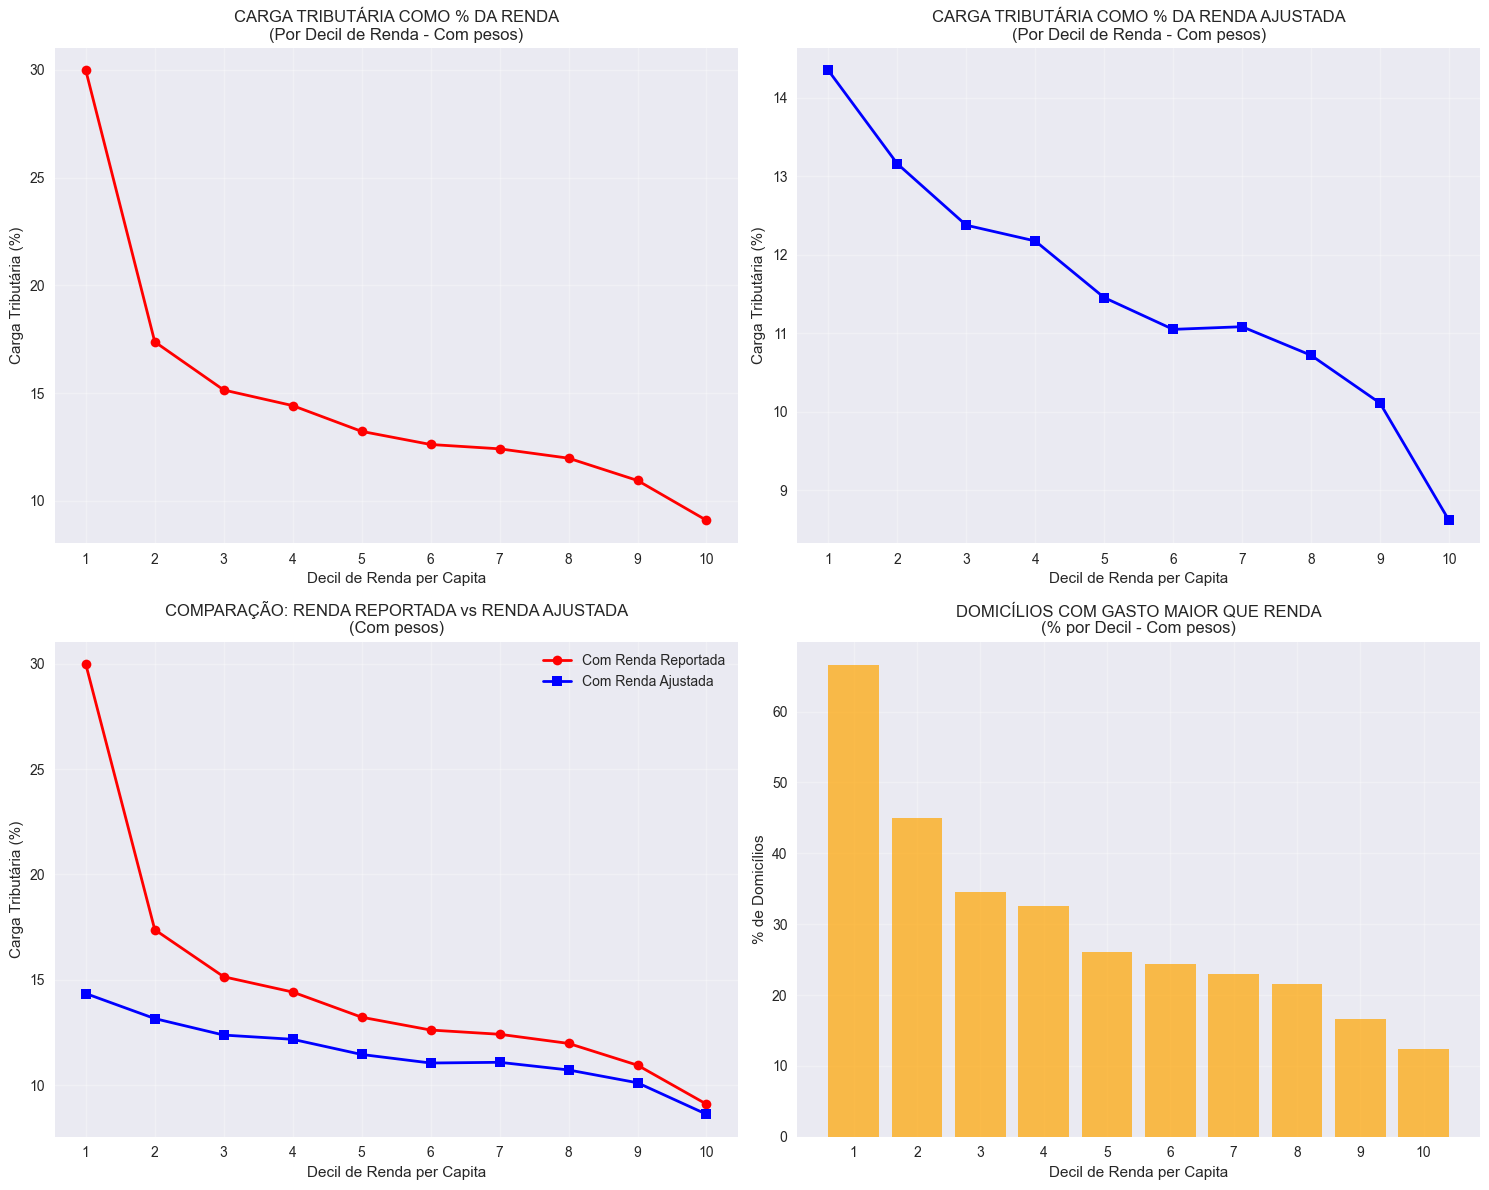

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Carga tributária como % da renda
axes[0,0].plot(carga_renda_decil.index, carga_renda_decil.values, 
               marker='o', linewidth=2, color='red', label='% da Renda')
axes[0,0].set_title('CARGA TRIBUTÁRIA COMO % DA RENDA\n(Por Decil de Renda - Com pesos)')
axes[0,0].set_xlabel('Decil de Renda per Capita')
axes[0,0].set_ylabel('Carga Tributária (%)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(range(1, 11))

# Gráfico 2: Carga tributária como % da renda ajustada
axes[0,1].plot(carga_renda_ajustada_decil.index, carga_renda_ajustada_decil.values, 
               marker='s', linewidth=2, color='blue', label='% da Renda Ajustada')
axes[0,1].set_title('CARGA TRIBUTÁRIA COMO % DA RENDA AJUSTADA\n(Por Decil de Renda - Com pesos)')
axes[0,1].set_xlabel('Decil de Renda per Capita')
axes[0,1].set_ylabel('Carga Tributária (%)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(range(1, 11))

# Gráfico 3: Comparação renda vs renda ajustada
axes[1,0].plot(carga_renda_decil.index, carga_renda_decil.values, 
               marker='o', linewidth=2, color='red', label='Com Renda Reportada')
axes[1,0].plot(carga_renda_ajustada_decil.index, carga_renda_ajustada_decil.values, 
               marker='s', linewidth=2, color='blue', label='Com Renda Ajustada')
axes[1,0].set_title('COMPARAÇÃO: RENDA REPORTADA vs RENDA AJUSTADA\n(Com pesos)')
axes[1,0].set_xlabel('Decil de Renda per Capita')
axes[1,0].set_ylabel('Carga Tributária (%)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(range(1, 11))

# Gráfico 4: Déficit orçamentário por decil (com pesos)
deficit_por_decil = df.groupby('DECIL_RENDA_PC').apply(
    lambda x: np.average(x['GASTO_MAIOR_RENDA'], weights=x['PESO'])
) * 100

axes[1,1].bar(deficit_por_decil.index, deficit_por_decil.values, 
              color='orange', alpha=0.7)
axes[1,1].set_title('DOMICÍLIOS COM GASTO MAIOR QUE RENDA\n(% por Decil - Com pesos)')
axes[1,1].set_xlabel('Decil de Renda per Capita')
axes[1,1].set_ylabel('% de Domicílios')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(range(1, 11))

plt.tight_layout()
plt.savefig('analise_regressividade_tributacao_indireta_corrigida.png', dpi=300, bbox_inches='tight')
plt.show()

### Análise de regressividade

In [41]:
# Calcular indicadores de regressividade
carga_decil_1_renda = carga_renda_decil.iloc[0]
carga_decil_10_renda = carga_renda_decil.iloc[9]
carga_decil_1_ajustada = carga_renda_ajustada_decil.iloc[0]
carga_decil_10_ajustada = carga_renda_ajustada_decil.iloc[9]

print("🔍 ANÁLISE DE REGRESSIVIDADE (COM PESOS):")
print(f"   COM RENDA REPORTADA:")
print(f"   - Decil 1 (mais pobre): {carga_decil_1_renda:.2f}%")
print(f"   - Decil 10 (mais rico): {carga_decil_10_renda:.2f}%")
print(f"   - Diferença (D10-D1): {carga_decil_10_renda - carga_decil_1_renda:.2f} pp")

print(f"\n   COM RENDA AJUSTADA:")
print(f"   - Decil 1 (mais pobre): {carga_decil_1_ajustada:.2f}%")
print(f"   - Decil 10 (mais rico): {carga_decil_10_ajustada:.2f}%")
print(f"   - Diferença (D10-D1): {carga_decil_10_ajustada - carga_decil_1_ajustada:.2f} pp")

# Determinar se é regressivo
if carga_decil_1_ajustada > carga_decil_10_ajustada:
    resultado = "REGRESSIVO"
    explicacao = "Os mais pobres pagam proporcionalmente mais impostos que os mais ricos"
elif carga_decil_1_ajustada < carga_decil_10_ajustada:
    resultado = "PROGRESSIVO"
    explicacao = "Os mais ricos pagam proporcionalmente mais impostos que os mais pobres"
else:
    resultado = "PROPORCIONAL"
    explicacao = "Todos pagam a mesma proporção de impostos em relação à renda"

print(f"\nRESULTADO: O sistema tributário indireto é {resultado}")
print(f"    {explicacao}")


🔍 ANÁLISE DE REGRESSIVIDADE (COM PESOS):
   COM RENDA REPORTADA:
   - Decil 1 (mais pobre): 29.98%
   - Decil 10 (mais rico): 9.09%
   - Diferença (D10-D1): -20.89 pp

   COM RENDA AJUSTADA:
   - Decil 1 (mais pobre): 14.35%
   - Decil 10 (mais rico): 8.62%
   - Diferença (D10-D1): -5.73 pp

RESULTADO: O sistema tributário indireto é REGRESSIVO
    Os mais pobres pagam proporcionalmente mais impostos que os mais ricos


In [42]:
# Criar relatório consolidado
relatorio_regressividade = pd.DataFrame({
    'DECIL': range(1, 11),
    'PONTO_CORTE_RENDA_PC': [f"Até R$ {deciles[0]:.2f}"] + 
                            [f"R$ {deciles[i-1]:.2f} a R$ {deciles[i]:.2f}" for i in range(1, 9)] + 
                            [f"Acima de R$ {deciles[8]:.2f}"],
    'CARGA_RENDA_REPORTADA_%': carga_renda_decil.values,
    'CARGA_RENDA_AJUSTADA_%': carga_renda_ajustada_decil.values,
    'DOMICILIOS_GASTO_MAIOR_RENDA_%': deficit_por_decil.values,
    'POPULACAO_REPRESENTADA': distribuicao_peso.values
}).round(3)

print("\n📊 RELATÓRIO CONSOLIDADO:")
print(relatorio_regressividade)

# Exportar para Excel
with pd.ExcelWriter('resultados_regressividade_tributacao_indireta_corrigido.xlsx') as writer:
    df.to_excel(writer, sheet_name='Dados_Completos', index=False)
    relatorio_regressividade.to_excel(writer, sheet_name='Analise_Decis', index=False)
    
    # Resumo executivo
    resumo = pd.DataFrame({
        'INDICADOR': [
            'Sistema Tributário Indireto',
            'Carga tributária média (% renda reportada)',
            'Carga tributária média (% renda ajustada)',
            'Domicílios com gasto > renda',
            'Regressividade (com renda reportada)',
            'Regressividade (com renda ajustada)',
            'Decil 1 - Carga tributária (% renda ajustada)',
            'Decil 10 - Carga tributária (% renda ajustada)',
            'Diferencial D10-D1 (pp)'
        ],
        'VALOR': [
            resultado,
            f"{np.average(df['TI_RENDA'], weights=df['PESO']):.2f}%",
            f"{np.average(df['TI_RENDA_A'], weights=df['PESO']):.2f}%",
            f"{np.average(df['GASTO_MAIOR_RENDA'], weights=df['PESO']) * 100:.1f}%",
            'Regressivo' if carga_decil_1_renda > carga_decil_10_renda else 'Progressivo',
            resultado,
            f"{carga_decil_1_ajustada:.2f}%",
            f"{carga_decil_10_ajustada:.2f}%",
            f"{carga_decil_10_ajustada - carga_decil_1_ajustada:.2f} pp"
        ]
    })
    resumo.to_excel(writer, sheet_name='Resumo_Executivo', index=False)

print(f"\nResultados exportados para 'resultados_regressividade_tributacao_indireta_corrigido.xlsx'")


📊 RELATÓRIO CONSOLIDADO:
   DECIL     PONTO_CORTE_RENDA_PC  CARGA_RENDA_REPORTADA_%  \
0      1            Até R$ 396.33                   29.981   
1      2    R$ 396.33 a R$ 615.79                   17.378   
2      3    R$ 615.79 a R$ 825.33                   15.143   
3      4   R$ 825.33 a R$ 1059.16                   14.418   
4      5  R$ 1059.16 a R$ 1293.29                   13.222   
5      6  R$ 1293.29 a R$ 1581.63                   12.613   
6      7  R$ 1581.63 a R$ 1998.97                   12.412   
7      8  R$ 1998.97 a R$ 2709.99                   11.978   
8      9  R$ 2709.99 a R$ 4366.71                   10.943   
9     10      Acima de R$ 4366.71                    9.094   

   CARGA_RENDA_AJUSTADA_%  DOMICILIOS_GASTO_MAIOR_RENDA_%  \
0                  14.346                          66.528   
1                  13.157                          44.965   
2                  12.374                          34.561   
3                  12.173                      